# Evaluate sampling representation of the ship track
- Extract data from ERA-5 along the ship track
- Compare actual data to ERA-5 along ship track to ERA-5 over whole region
- Compare sampling along planned and actual track

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from thermo_functions import *
from time_series_diag import *
from bowtie_read_data import *

In [3]:
#Open ERA-5 Data
era5 = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/data/ERA5_hrly_OLR_Prec_PW_20240809.nc')
era5

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1464, latitude: 241, longitude: 601)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2024-08-01 ... 2024-09-30T23...
  * latitude    (latitude) float64 2kB 50.0 49.75 49.5 ... -9.5 -9.75 -10.0
  * longitude   (longitude) float64 5kB -90.0 -89.75 -89.5 ... 59.5 59.75 60.0
    expver      (valid_time) <U4 23kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 848MB ...
    mtpr        (valid_time, latitude, longitude) float32 848MB ...
    mtnlwrf     (valid_time, latitude, longitude) float32 848MB ...
    ttr         (valid_time, latitude, longitude) float32 848MB ...
    tcwv        (valid_time, latitude, longitude) float32 848MB ...
Attributes:
    GRIB_centre:                ecmf
    GRIB_centreDescription:     European Centre for Medium-Range Weather Fore...
    GRIB_subCentre:             0
    Conventions:                CF-1.7
    institution:                European Centre for Medium-Range Weather Fore...
    history:                    Mon Nov 11 14:56:15 2024: ncks -A -v tcwv ERA...
    history_of_appended_files:  Mon Nov 11 14:56:15 2024: Appended file ERA5_...
    NCO:                        netCDF Operators version 5.1.5 (Homepage = ht...

In [4]:
#Open ship data
DSHIP = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/data/meteor_meteo_dship_20240923.nc')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
Data variables: (12/39)
    sst_port          (time) float64 472kB ...
    sst_extern_port   (time) float64 472kB ...
    sst_intern_port   (time) float64 472kB ...
    sst_board         (time) float64 472kB ...
    sst_extern_board  (time) float64 472kB ...
    sst_intern_board  (time) float64 472kB ...
    ...                ...
    ship_heave        (time) float64 472kB ...
    ship_heave_std    (time) float64 472kB ...
    ship_pitch        (time) float64 472kB ...
    ship_pitch_std    (time) float64 472kB ...
    ship_roll         (time) float64 472kB ...
    ship_roll_std     (time) float64 472kB ...

In [5]:
#Set start and end times. Use ERA-5 time variable, which is hourly

start_time = np.datetime64('2024-08-14T21:00:00')
index_start = np.where(pd.to_datetime(era5.valid_time) == start_time)[0]
index_start = int(index_start[0])

end_time = np.datetime64('2024-09-23T23:00:00')
index_end = np.where(pd.to_datetime(era5.valid_time) == end_time)[0]
index_end = int(index_end[0])

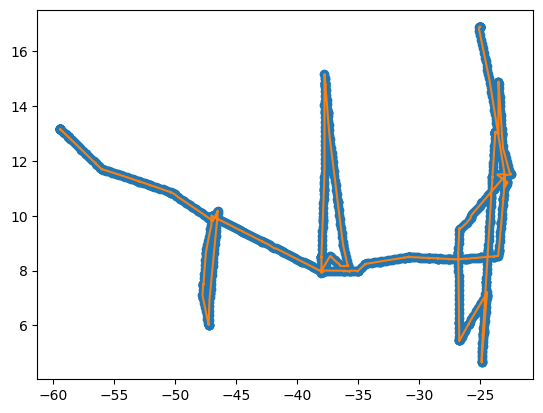

In [6]:
#Interpolate ship position to ERA-5 times
ship_lat_interp = np.interp(era5.valid_time[index_start:index_end+1], DSHIP.time, DSHIP.lat)
ship_lon_interp = np.interp(era5.valid_time[index_start:index_end+1], DSHIP.time, DSHIP.lon)

plt.plot(ship_lon_interp, ship_lat_interp,'o')
plt.plot(DSHIP.lon, DSHIP.lat,'-')

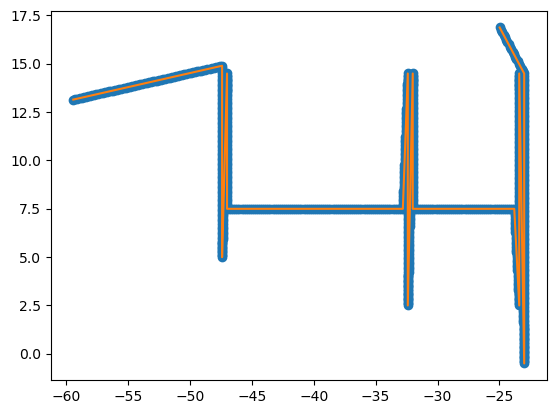

In [7]:
#planned track
# Load JSON data from a file
with open('track_planned.json', 'r') as file:
    planned_track = json.load(file)

# Convert JSON data to a DataFrame
planned_track_df = pd.DataFrame(planned_track)

#Convert track_time to datetime
planned_track_df['track_time'] = pd.to_datetime(planned_track_df['track_time'])

#Convert DataFrame to xarray.Dataset
planned_track_ds = planned_track_df.set_index('track_time').to_xarray()

#Interpolate planned track to ERA-5 times
start_time_planned = np.datetime64('2024-08-10T12:00:00')
index_start_planned = np.where(pd.to_datetime(era5.valid_time) == start_time_planned)[0]
index_start_planned = int(index_start_planned[0])

end_time_planned = np.datetime64('2024-09-23T20:00:00')
index_end_planned = np.where(pd.to_datetime(era5.valid_time) == end_time_planned)[0]
index_end_planned = int(index_end_planned[0])

planned_lat_interp = np.interp(era5.valid_time[index_start_planned:index_end_planned+1], planned_track_ds.track_time, planned_track_ds.track_lat)
planned_lon_interp = np.interp(era5.valid_time[index_start_planned:index_end_planned+1], planned_track_ds.track_time, planned_track_ds.track_lon)

plt.plot(planned_lon_interp, planned_lat_interp,'o')
plt.plot(planned_track_ds.track_lon, planned_track_ds.track_lat,'-')


Extract data from ERA-5 along ship track

In [8]:
#Extract OLR, Precipitation, and PW from ERA-5 at ship location at each hour (use interpolated ship position)

PW_alongtrack = np.full(len(ship_lat_interp), np.nan)
Prec_alongtrack = np.full(len(ship_lat_interp), np.nan)
OLR_alongtrack = np.full(len(ship_lat_interp), np.nan)

count = 0
for itime in range(index_start, index_end+1):
    PW_alongtrack[count] = era5.tcwv.sel(latitude=ship_lat_interp[count], longitude=ship_lon_interp[count], valid_time=era5.valid_time[itime], method='nearest').values
    Prec_alongtrack[count] = era5.mtpr.sel(latitude=ship_lat_interp[count], longitude=ship_lon_interp[count], valid_time=era5.valid_time[itime], method='nearest').values
    OLR_alongtrack[count] = era5.mtnlwrf.sel(latitude=ship_lat_interp[count], longitude=ship_lon_interp[count], valid_time=era5.valid_time[itime], method='nearest').values

    count += 1

In [9]:
#Extract along planned ship track

PW_alongtrack_planned = np.full(len(planned_lat_interp), np.nan)
Prec_alongtrack_planned = np.full(len(planned_lat_interp), np.nan)
OLR_alongtrack_planned = np.full(len(planned_lat_interp), np.nan)

count=0
for itime in range(index_start_planned, index_end_planned+1):
    PW_alongtrack_planned[count] = era5.tcwv.sel(latitude=planned_lat_interp[count], longitude=planned_lon_interp[count], valid_time=era5.valid_time[itime], method='nearest').values
    Prec_alongtrack_planned[count] = era5.mtpr.sel(latitude=planned_lat_interp[count], longitude=planned_lon_interp[count], valid_time=era5.valid_time[itime], method='nearest').values
    OLR_alongtrack_planned[count] = era5.mtnlwrf.sel(latitude=planned_lat_interp[count], longitude=planned_lon_interp[count], valid_time=era5.valid_time[itime], method='nearest').values


    count += 1

Text(0.5, 1.0, 'Column-Integrated Water Vapor from ERA-5 along track')

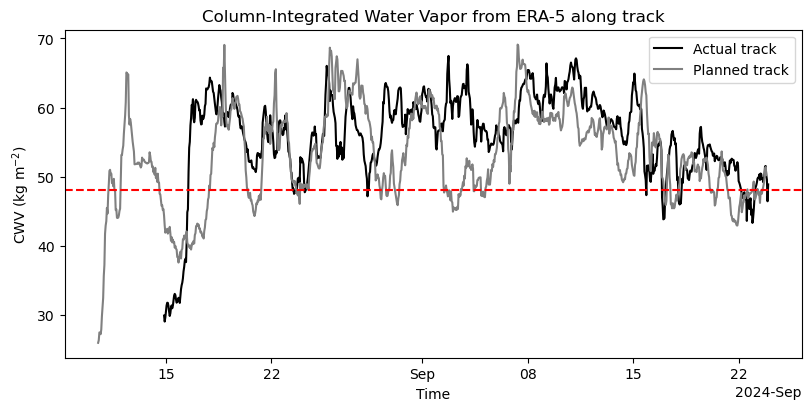

In [10]:
fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

ax.plot(era5.valid_time[index_start:index_end+1],PW_alongtrack,'k',label='Actual track')
ax.plot(era5.valid_time[index_start_planned:index_end_planned+1],PW_alongtrack_planned,'gray',label='Planned track')
ax.axhline(48, color='red', linestyle='--')

plt.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel('Time')
ax.set_ylabel('CWV (kg m$^{-2}$)')
ax.set_title('Column-Integrated Water Vapor from ERA-5 along track')

In [11]:
#Collect ERA-5 data at all times throughout ship track and all locations within box of interest
lat1 = 17
lat2 = 4.5
lon1 = -60
lon2 = -22

PW_box = era5.tcwv.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))
PW_box = PW_box[index_start:index_end+1,:,:]

Prec_box = era5.mtpr.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))
Prec_box = Prec_box[index_start:index_end+1,:,:]

OLR_box = era5.mtnlwrf.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))
OLR_box = OLR_box[index_start:index_end+1,:,:] 


Evaluate sampling distribution of ship track compared to full region within ERA-5

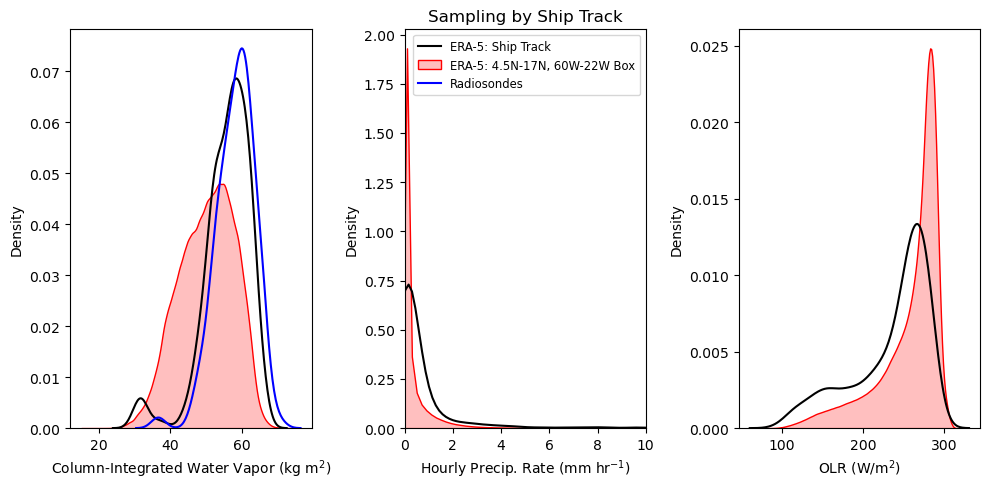

In [24]:
# Create probability density plots

fig, axs = plt.subplots(1,3,figsize=(10,5))

sns.kdeplot(PW_alongtrack, ax=axs[0],label='ERA-5: Ship Track',fill=False, common_norm=False,color='black')
#sns.kdeplot(PW_alongtrack_planned, ax=axs[0],label='ERA-5: Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(PW_box.values.flatten(), ax=axs[0],label='ERA-5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
sns.kdeplot(cwv_finite,ax=axs[0],label='Radiosondes',fill=False,common_norm=False,color='blue')
axs[0].set_xlabel('Column-Integrated Water Vapor (kg m$^2$)')
axs[0].set_ylabel('Density')
#axs[0].legend()

sns.kdeplot(Prec_alongtrack*3600, ax=axs[1],label='ERA-5: Ship Track',fill=False,common_norm=False,color='black')
#sns.kdeplot(Prec_alongtrack_planned*3600, ax=axs[1],label='ERA-5:Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(Prec_box.values.flatten()*3600, ax=axs[1],label='ERA-5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
axs[1].set_title('Sampling by Ship Track')
axs[1].set_xlabel('Hourly Precip. Rate (mm hr$^{-1}$)')
axs[1].set_ylabel('Density')
axs[1].set_xlim(0,10)
#axs[1].legend()

sns.kdeplot(OLR_alongtrack*-1, ax=axs[2],label='ERA-5: Ship Track',fill=False,common_norm=False,color='black')
#sns.kdeplot(OLR_alongtrack_planned*-1, ax=axs[2],label='ERA-5: Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(OLR_box.values.flatten()*-1,ax=axs[2],label='ERA-5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
axs[2].set_xlabel('OLR (W/m$^2$)')
axs[2].set_ylabel('Density')
#axs[2].legend()

#add legend
# Get handles and labels from axs[0]
handles, labels = axs[0].get_legend_handles_labels()
# Add legend to axs[1]
axs[1].legend(handles, labels, loc='upper right',fontsize='small')

plt.tight_layout()
plt.show()

#save figure
fig.savefig('Fig_track_representativeness.png')


Consider only data where PW > 48 mm, to consider sampling within the ITCZ

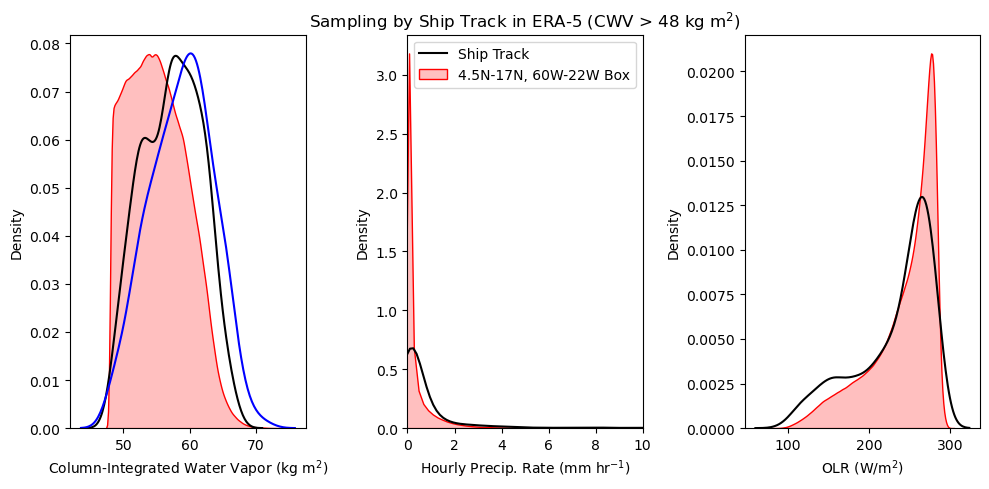

In [25]:
#Compare sampling just within 48 mm contour of PW - include only data where PW > 48 mm
PW_alongtrack_48 = PW_alongtrack[PW_alongtrack > 48]
PW_alongtrack_planned_48 = PW_alongtrack_planned[PW_alongtrack_planned > 48]
PW_box_48 = PW_box.values[PW_box.values > 48]

Prec_alongtrack_48 = Prec_alongtrack[PW_alongtrack > 48]
Prec_alongtrack_planned_48 = Prec_alongtrack_planned[PW_alongtrack_planned > 48]
Prec_box_48 = Prec_box.values[PW_box.values > 48]

OLR_alongtrack_48 = OLR_alongtrack[PW_alongtrack > 48]
OLR_alongtrack_planned_48 = OLR_alongtrack_planned[PW_alongtrack_planned > 48]
OLR_box_48 = OLR_box.values[PW_box.values > 48]

fig, axs = plt.subplots(1,3,figsize=(10,5))

sns.kdeplot(PW_alongtrack_48, ax=axs[0],label='Ship Track',fill=False, common_norm=False,color='black')
#sns.kdeplot(PW_alongtrack_planned_48, ax=axs[0],label='Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(PW_box_48, ax=axs[0],label='4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
sns.kdeplot(cwv_finite[cwv_finite>48],ax=axs[0],label='Radiosondes',fill=False,common_norm=False,color='blue')
#axs[0].set_title('Representativeness of Ship Track')
axs[0].set_xlabel('Column-Integrated Water Vapor (kg m$^2$)')
axs[0].set_ylabel('Density')
#axs[0].legend()

sns.kdeplot(Prec_alongtrack_48*3600, ax=axs[1],label='Ship Track',fill=False,common_norm=False,color='black')
#sns.kdeplot(Prec_alongtrack_planned_48*3600, ax=axs[1],label='Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(Prec_box_48*3600, ax=axs[1],label='4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
axs[1].set_title('Sampling by Ship Track in ERA-5 (CWV > 48 kg m$^2$)')
axs[1].set_xlabel('Hourly Precip. Rate (mm hr$^{-1}$)')
axs[1].set_ylabel('Density')
axs[1].set_xlim(0,10)
axs[1].legend()

sns.kdeplot(OLR_alongtrack_48*-1, ax=axs[2],label='Ship Track',fill=False,common_norm=False,color='black')
#sns.kdeplot(OLR_alongtrack_planned_48*-1, ax=axs[2],label='Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(OLR_box_48*-1,ax=axs[2],label='4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
#axs[2].set_title('Representativeness of Ship Track')
axs[2].set_xlabel('OLR (W/m$^2$)')
axs[2].set_ylabel('Density')
#axs[2].legend()

plt.tight_layout()
plt.show()

fig.savefig('Fig_track_representativeness_48.png')

# Compare to Radiosonde Data

Read in radiosonde data

In [15]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

Define functions

In [16]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

# Smooth a variable in the vertical
def smooth_var_z(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    # Need to transpose first to put vertical in the first dimension position
    invar_pd = invar_pd.transpose().rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # Then un-transpose
    return np.squeeze(np.array(invar_pd.transpose()))

Calculate column-integrated water vapor

In [17]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [18]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

In [19]:
#Mask out soundings that don't reach 100 hPa
 
nt = snd_asc['p'].shape[0]
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_27706/1962452099.py:6: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa


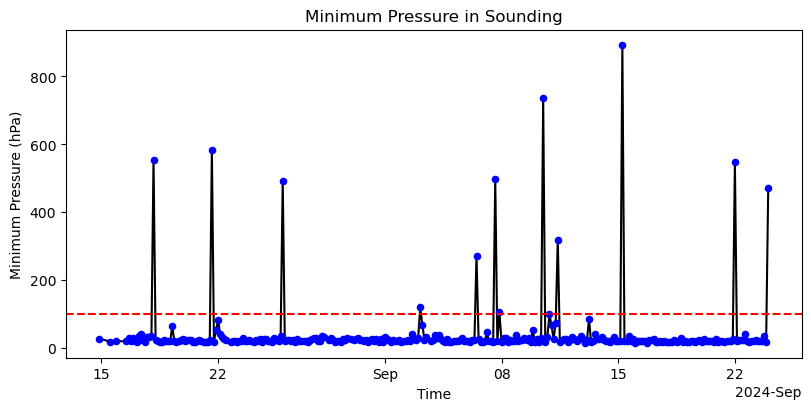

In [20]:
fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

finite = np.where(np.isfinite(min_pres))
ax.plot(times_asc[finite], min_pres[finite], color='black', label='Min. Pressure', zorder=1)
ax.scatter(times_asc[finite], min_pres[finite], color='blue', s = 20,zorder=2)
ax.axhline(100, color='red', linestyle='--', label='100 hPa')

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title('Minimum Pressure in Sounding')
ax.set_ylabel('Minimum Pressure (hPa)')
ax.set_xlabel('Time')

plt.show()

Plot CWV from radiosonde data and ERA-5

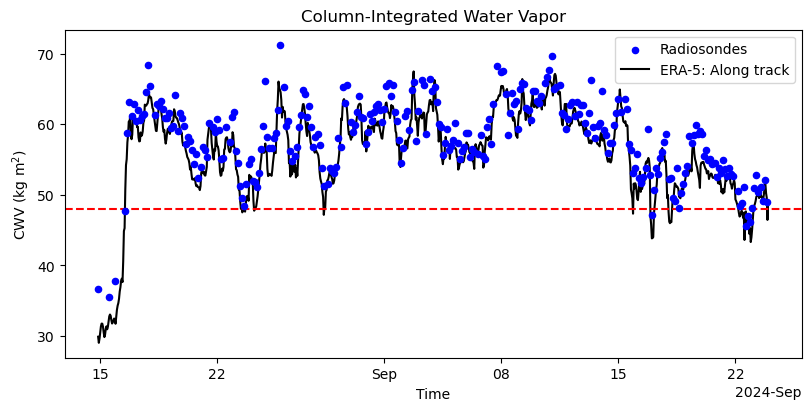

In [21]:
fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

#radiosonde data
finite = np.where(np.isfinite(cwv))
cwv_finite = cwv[finite]
#ax.plot(times_asc[finite], cwv_finite, color='blue', label='Radiosondes', zorder=3)
ax.scatter(times_asc[finite], cwv_finite, color='blue', s = 20, label='Radiosondes',zorder=3)

#ERA-5 data 
ax.plot(era5.valid_time[index_start:index_end+1],PW_alongtrack,'black',label='ERA-5: Along track',zorder=2)
#ax.plot(era5.valid_time[index_start_planned:index_end_planned+1],PW_alongtrack_planned,'gray',label='ERA-5: Planned track',zorder=1)

ax.axhline(48, color='red', linestyle='--')

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title('Column-Integrated Water Vapor')
ax.set_ylabel('CWV (kg m$^2$)')
ax.set_xlabel('Time')

plt.legend()
plt.show()

Plot radiosonde CWV distribution along with ERA-5 distributions

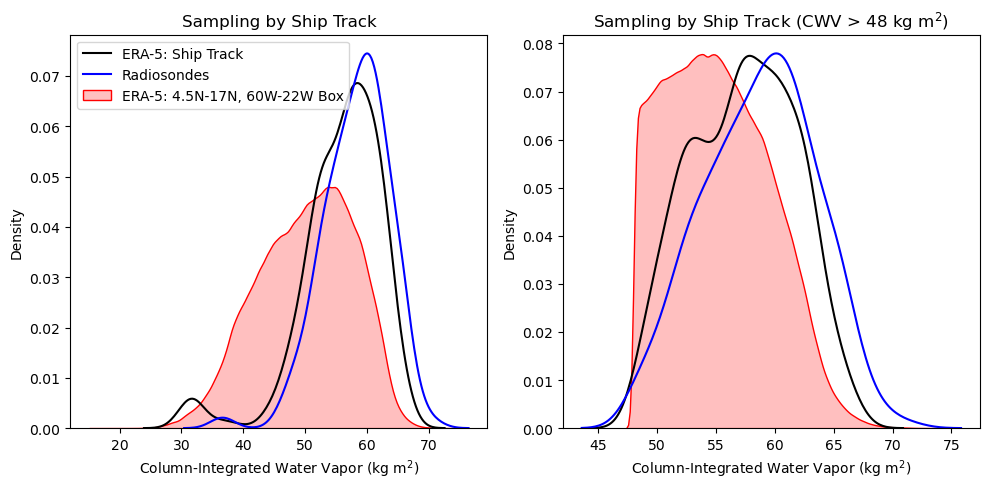

In [26]:
# Create probability density plots

fig, axs = plt.subplots(1,2,figsize=(10,5))

sns.kdeplot(PW_alongtrack,ax=axs[0],label='ERA-5: Ship Track',fill=False, common_norm=False,color='black')
sns.kdeplot(cwv_finite,ax=axs[0],label='Radiosondes',fill=False,common_norm=False,color='blue')
#sns.kdeplot(PW_alongtrack_planned,ax=axs[0],label='ERA-5: Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(PW_box.values.flatten(),ax=axs[0],label='ERA-5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
axs[0].set_title('Sampling by Ship Track')
axs[0].set_xlabel('Column-Integrated Water Vapor (kg m$^2$)')
axs[0].set_ylabel('Density')

axs[0].legend()

sns.kdeplot(PW_alongtrack_48,ax=axs[1],label='ERA-5: Ship Track',fill=False,common_norm=False, color='black')
sns.kdeplot(cwv_finite[cwv_finite>48],ax=axs[1],label='Radiosondes',fill=False,common_norm=False,color='blue')
#sns.kdeplot(PW_alongtrack_planned_48,ax=axs[1],label='ERA-5: Planned Track',fill=False,common_norm=False,color='gray')
sns.kdeplot(PW_box_48,ax=axs[1],label='ERA-5: 4.5N-17N, 60W-22W Box',fill=True,common_norm=False,color='red')
axs[1].set_title('Sampling by Ship Track (CWV > 48 kg m$^2$)')
axs[1].set_xlabel('Column-Integrated Water Vapor (kg m$^2$)')
axs[1].set_ylabel('Density')

#axs[1].legend()

plt.tight_layout()
plt.show()

fig.savefig('Fig_CWV_track_representativeness_sondes.png')

Text(0.5, 0, 'CWV(kg m$^2$)')

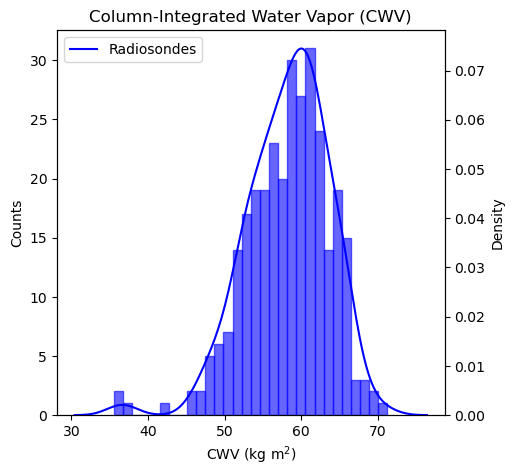

In [27]:
# Create probability density plots

fig,ax1 = plt.subplots(figsize = (5, 5))

# Plot histogram with counts
counts, bins, patches = ax1.hist(cwv_finite, bins=30, alpha=0.6, color='b', edgecolor='b')
ax1.set_xlabel('CWV (kg m$^2$)')
ax1.set_ylabel('Counts', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create a second y-axis for the KDE plot
ax2 = ax1.twinx()

# Plot KDE probability density
sns.kdeplot(cwv_finite, common_norm=False, ax=ax2, color='b',label='Radiosondes')
ax2.set_ylabel('Density', color='k')
ax2.tick_params(axis='y', labelcolor='k')

#sns.histplot(cwv_finite,kde=False,bins=30,color='blue')
#sns.kdeplot(cwv_finite,label='Radiosondes',fill=False,color='blue')
plt.legend()
plt.title('Column-Integrated Water Vapor (CWV)')
plt.xlabel('CWV(kg m$^2$)')
#plt.ylabel('Probability Density')